# Digress MNIST training

In [9]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [10]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [12]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break


Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [20]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [25]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

In [26]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [27]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [28]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.949484  [   64/60000]
loss: 0.461387  [ 6464/60000]
loss: 0.339331  [12864/60000]
loss: 0.390402  [19264/60000]
loss: 0.245571  [25664/60000]
loss: 0.310738  [32064/60000]
loss: 0.194456  [38464/60000]
loss: 0.287325  [44864/60000]
loss: 0.260160  [51264/60000]
loss: 0.283899  [57664/60000]
Test Error: 
 Accuracy: 93.6%, Avg loss: 0.212028 

Epoch 2
-------------------------------
loss: 0.114760  [   64/60000]
loss: 0.174532  [ 6464/60000]
loss: 0.121783  [12864/60000]
loss: 0.263181  [19264/60000]
loss: 0.108847  [25664/60000]
loss: 0.224819  [32064/60000]
loss: 0.096149  [38464/60000]
loss: 0.217490  [44864/60000]
loss: 0.166119  [51264/60000]
loss: 0.205873  [57664/60000]
Test Error: 
 Accuracy: 95.6%, Avg loss: 0.142044 

Epoch 3
-------------------------------
loss: 0.065680  [   64/60000]
loss: 0.122843  [ 6464/60000]
loss: 0.098434  [12864/60000]
loss: 0.164721  [19264/60000]
loss: 0.064329  [25664/60000]
loss: 0.159539  [32064/600

In [67]:
for x, y in test_data:
    print('Output:', model(x.cuda()).argmax().item())
    print('Pred:', y)
    break

Output: 7
Pred: 7


In [45]:
model

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [54]:
import matplotlib.pyplot as plt

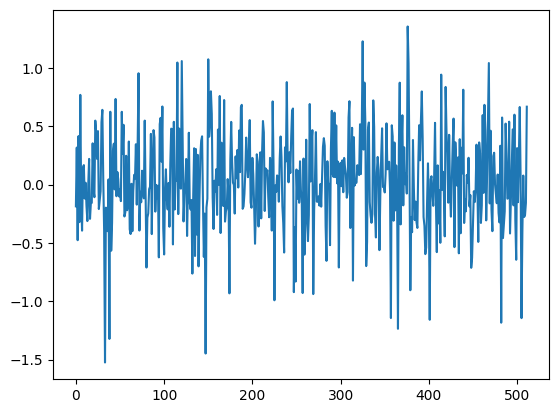

In [60]:
plt.plot(range(512), model.linear_relu_stack[0](x.cuda().flatten()).detach().cpu().numpy())

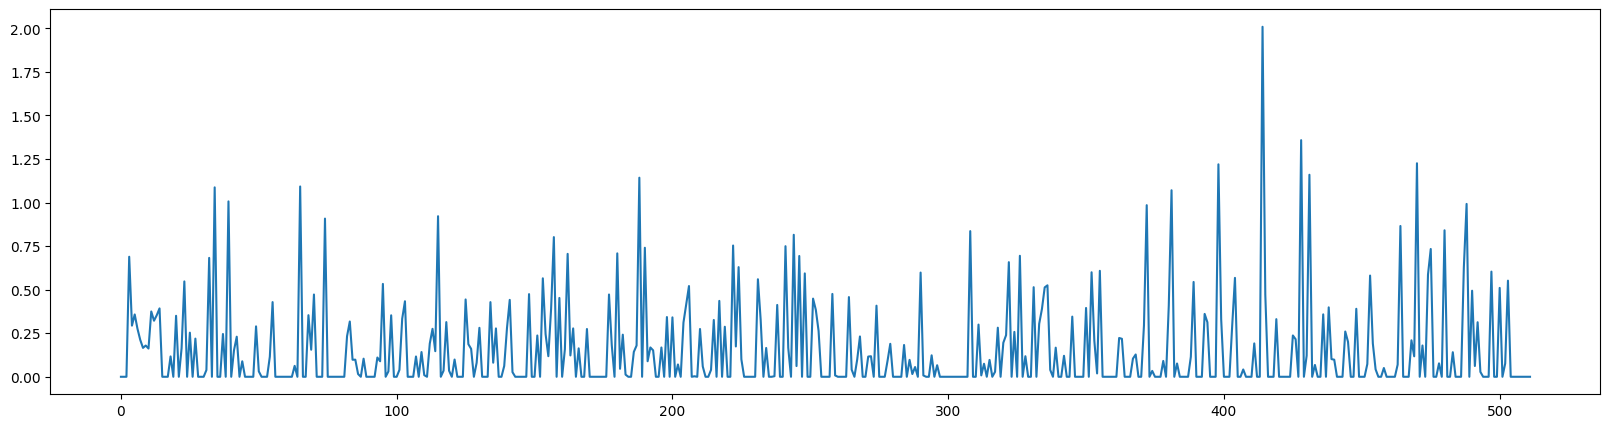

In [64]:
plt.figure(figsize=(20,5))
plt.plot(range(512), model.linear_relu_stack[0:2](test_data[4][0].cuda().flatten()).detach().cpu().numpy())

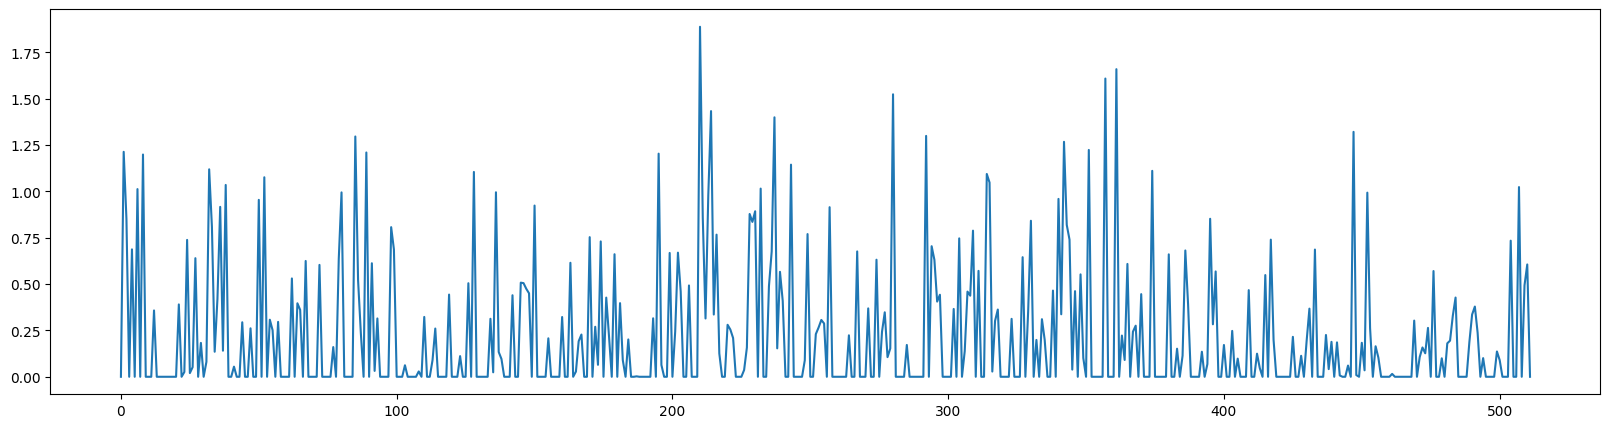

In [65]:
plt.figure(figsize=(20,5))
plt.plot(range(512), model.linear_relu_stack[0:2](test_data[1][0].cuda().flatten()).detach().cpu().numpy())

For some inputs to the neural network certain neurons will produce negative pre-activations, which is what ReLU clips, indicating that those neurons are not required during computation for this particular input. Also neurons that have negative pre-activations are not updated for that input and only updated for inputs whose pre-activation is positive.

# A bit of basics

In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [119]:
mu = torch.randn(2)
logvar = torch.randn(2)

In [120]:
mu, logvar

(tensor([ 0.9482, -0.4706]), tensor([0.5658, 0.8797]))

In [121]:
scale = F.softplus(logvar) + 1e-5
scale

tensor([1.0156, 1.2268])

In [122]:
scale_diag = torch.diag_embed(scale)
scale_diag

tensor([[1.0156, 0.0000],
        [0.0000, 1.2268]])

In [123]:
dist = torch.distributions.MultivariateNormal(mu, scale_diag)
dist

MultivariateNormal(loc: torch.Size([2]), covariance_matrix: torch.Size([2, 2]))

(-3.2348574876785277,
 5.9522079706192015,
 -5.602608180046081,
 4.4962644338607785)

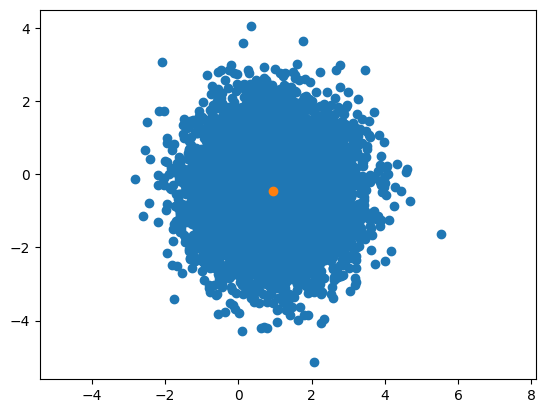

In [124]:
plt.scatter(*zip(*dist.sample((10000,)).numpy()))
plt.scatter(*mu)
plt.axis('equal')

In [127]:
x = torch.randn(5)
x

tensor([-0.0817,  0.0040, -0.7447, -0.3464,  1.3860])

In [129]:
F.cross_entropy(x, torch.tensor(2))

tensor(2.7057)

In [133]:
-torch.log(F.softmax(x, dim=0)[2])

tensor(2.7057)

In [135]:
x = torch.randn(10, 5)
y = torch.randn(10, 5)
x = F.sigmoid(x)
y = F.sigmoid(x)
x, y

(tensor([[0.7236, 0.6127, 0.3557, 0.5443, 0.6369],
         [0.5193, 0.6524, 0.6435, 0.7601, 0.3437],
         [0.5610, 0.2179, 0.4273, 0.7237, 0.1051],
         [0.7074, 0.4350, 0.1889, 0.1285, 0.4533],
         [0.7400, 0.5370, 0.2975, 0.2436, 0.6842],
         [0.5955, 0.7948, 0.5320, 0.6950, 0.3057],
         [0.4627, 0.6156, 0.3285, 0.5989, 0.4906],
         [0.5080, 0.6233, 0.4332, 0.5860, 0.2940],
         [0.2109, 0.6942, 0.2311, 0.6415, 0.6199],
         [0.3313, 0.3498, 0.5619, 0.4014, 0.2938]]),
 tensor([[0.6734, 0.6486, 0.5880, 0.6328, 0.6540],
         [0.6270, 0.6576, 0.6555, 0.6814, 0.5851],
         [0.6367, 0.5543, 0.6052, 0.6734, 0.5262],
         [0.6698, 0.6071, 0.5471, 0.5321, 0.6114],
         [0.6770, 0.6311, 0.5738, 0.5606, 0.6647],
         [0.6446, 0.6889, 0.6299, 0.6671, 0.5758],
         [0.6137, 0.6492, 0.5814, 0.6454, 0.6202],
         [0.6243, 0.6510, 0.6066, 0.6424, 0.5730],
         [0.5525, 0.6669, 0.5575, 0.6551, 0.6502],
         [0.5821, 0.5866, 0.6

In [154]:
F.binary_cross_entropy(x, y, reduction='none')

tensor([[0.6378, 0.6511, 0.7889, 0.6735, 0.6455],
        [0.6841, 0.6427, 0.6443, 0.6418, 0.7996],
        [0.6671, 0.9542, 0.7347, 0.6378, 1.2383],
        [0.6376, 0.7296, 1.0065, 1.1562, 0.7184],
        [0.6390, 0.6765, 0.8462, 0.9144, 0.6388],
        [0.6558, 0.6510, 0.6786, 0.6380, 0.8372],
        [0.7129, 0.6503, 0.8140, 0.6548, 0.6978],
        [0.6893, 0.6485, 0.7308, 0.6587, 0.8501],
        [0.9659, 0.6381, 0.9331, 0.6446, 0.6493],
        [0.8113, 0.7941, 0.6668, 0.7525, 0.8504]])

In [157]:
-(y * torch.log(x) + (1-y) * torch.log(1-x)) # cross entropy

tensor([[0.6378, 0.6511, 0.7889, 0.6735, 0.6455],
        [0.6841, 0.6427, 0.6443, 0.6418, 0.7996],
        [0.6671, 0.9542, 0.7347, 0.6378, 1.2383],
        [0.6376, 0.7296, 1.0065, 1.1562, 0.7184],
        [0.6390, 0.6765, 0.8462, 0.9144, 0.6388],
        [0.6558, 0.6510, 0.6786, 0.6380, 0.8372],
        [0.7129, 0.6503, 0.8140, 0.6548, 0.6978],
        [0.6893, 0.6485, 0.7308, 0.6587, 0.8501],
        [0.9659, 0.6381, 0.9331, 0.6446, 0.6493],
        [0.8113, 0.7941, 0.6668, 0.7525, 0.8504]])

In [159]:
x = torch.randn(10, 5)
y = torch.randn(10, 5)
y = F.sigmoid(x)
x, y

(tensor([[ 8.5008e-01,  1.1503e+00, -9.0317e-01,  9.5221e-01,  9.9426e-01],
         [ 3.9728e-01,  2.4590e-03, -1.3186e+00, -9.5533e-01,  1.6014e+00],
         [-5.2648e-01, -4.9488e-01, -9.7266e-01,  3.5942e-01, -3.3057e+00],
         [ 2.4597e-01,  4.8672e-01,  6.3661e-01, -1.2076e+00, -4.2793e-01],
         [ 8.9078e-01,  5.1088e-01,  1.8264e+00,  8.0128e-01,  3.1012e-01],
         [ 1.3446e-01, -5.8606e-01,  1.7378e-01, -7.9215e-01, -3.9402e-01],
         [ 1.0794e+00,  1.0490e-02,  1.6955e+00, -9.6947e-01,  6.6511e-01],
         [-4.8319e-01,  3.7456e-01,  2.3775e-01,  5.7363e-01,  2.4032e-01],
         [-2.2859e-01, -8.1701e-01, -1.1279e+00, -1.4454e+00,  1.2508e+00],
         [ 1.1439e+00, -1.0919e+00,  1.2466e+00,  5.1911e-01, -6.0836e-02]]),
 tensor([[0.7006, 0.7596, 0.2884, 0.7216, 0.7299],
         [0.5980, 0.5006, 0.2111, 0.2778, 0.8322],
         [0.3713, 0.3787, 0.2744, 0.5889, 0.0354],
         [0.5612, 0.6193, 0.6540, 0.2301, 0.3946],
         [0.7091, 0.6250, 0.8613, 

In [161]:
F.binary_cross_entropy_with_logits(x, y, reduction='none')

tensor([[0.6104, 0.5516, 0.6007, 0.5915, 0.5833],
        [0.6738, 0.6931, 0.5154, 0.5909, 0.4524],
        [0.6597, 0.6634, 0.5875, 0.6773, 0.1530],
        [0.6856, 0.6644, 0.6449, 0.5394, 0.6708],
        [0.6030, 0.6616, 0.4025, 0.6189, 0.6813],
        [0.6909, 0.6520, 0.6894, 0.6205, 0.6741],
        [0.5663, 0.6931, 0.4314, 0.5882, 0.6408],
        [0.6648, 0.6759, 0.6861, 0.6536, 0.6860],
        [0.6867, 0.6162, 0.5563, 0.4873, 0.5301],
        [0.5529, 0.5637, 0.5310, 0.6606, 0.6927]])

In [164]:
x_ = F.sigmoid(x)
-(y * torch.log(x_) + (1-y) * torch.log(1-x_)) # cross entropy

tensor([[0.6104, 0.5516, 0.6007, 0.5915, 0.5833],
        [0.6738, 0.6931, 0.5154, 0.5909, 0.4524],
        [0.6597, 0.6634, 0.5875, 0.6773, 0.1530],
        [0.6856, 0.6644, 0.6449, 0.5394, 0.6708],
        [0.6030, 0.6616, 0.4025, 0.6189, 0.6813],
        [0.6909, 0.6520, 0.6894, 0.6205, 0.6741],
        [0.5663, 0.6931, 0.4314, 0.5882, 0.6408],
        [0.6648, 0.6759, 0.6861, 0.6536, 0.6860],
        [0.6867, 0.6162, 0.5563, 0.4873, 0.5301],
        [0.5529, 0.5637, 0.5310, 0.6606, 0.6927]])

In [167]:
x = torch.diag_embed(F.softplus(torch.randn(5)))
x

tensor([[0.2506, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4430, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.2153, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.4256, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.6914]])

In [168]:
torch.linalg.cholesky(x)

tensor([[0.5006, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.6656, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.4640, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.1940, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.8315]])

In [171]:
torch.sqrt(x)

tensor([[0.5006, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.6656, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.4640, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.1940, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.8315]])

In [277]:
mu = torch.randn(5)
logvar = torch.randn(5)
std = torch.exp(0.5 * logvar)
scale_tril = torch.diag_embed(std)
dist = torch.distributions.MultivariateNormal(mu, scale_tril=scale_tril)
normal = torch.distributions.MultivariateNormal(torch.zeros_like(mu), scale_tril=torch.eye(mu.shape[0]))

In [278]:
torch.distributions.kl_divergence(dist, normal)

tensor(3.8697)

In [279]:
-0.5 * torch.sum(1 + logvar - mu.square() - logvar.exp(), dim=-1)

tensor(3.8697)

# Finally its time

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
from torchvision import datasets
from torchvision.transforms import v2
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = 'cuda'

In [3]:
input_dim = 784
hidden_dim = 512
latent_dim = 2

@dataclass
class VAEOutput:
    x_recon: torch.Tensor
    z_dist: torch.distributions.MultivariateNormal
    z_sample: torch.Tensor
    loss_recon: torch.Tensor
    loss_kl: torch.Tensor
    total_loss: torch.Tensor

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.SiLU(),
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.SiLU(),
            nn.Linear(hidden_dim // 4, hidden_dim // 8),
            nn.SiLU(),
            nn.Linear(hidden_dim // 8, 2 * latent_dim),
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 8),
            nn.SiLU(),
            nn.Linear(hidden_dim // 8, hidden_dim // 4),
            nn.SiLU(),
            nn.Linear(hidden_dim // 4, hidden_dim // 2),
            nn.SiLU(),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid(),
        )

    
    def encode(self, x):
        x = self.encoder(x)
        mu, logvar = x.chunk(2, dim=-1)
        std = torch.exp(0.5 * logvar)
        scale_tril = torch.diag_embed(std)

        dist = torch.distributions.MultivariateNormal(
            mu,
            scale_tril=scale_tril
        )
        return dist, mu, logvar

    def decode(self, x):
        return self.decoder(x)
    
    def kl_divergence(self, mu, logvar):
        return torch.mean(-0.5 * torch.sum(1 + logvar - mu.square() - logvar.exp(), dim=-1))

    
    def forward(self, x, compute_loss=True):
        dist, mu, logvar = self.encode(x)
        z = dist.rsample() # sample using reparameterization
        x_recon = self.decode(z)

        if not compute_loss:
            return VAEOutput(
                x_recon = x_recon,
                z_dist = dist,
                z_sample = z,
                loss_recon = None,
                loss_kl = None,
                total_loss = None,
            )

        loss_recon = F.binary_cross_entropy(x_recon, x + 0.5, reduction='none').sum(-1).mean()
        loss_kl = self.kl_divergence(mu, logvar)
        total_loss = loss_recon + loss_kl
        
        return VAEOutput(
            x_recon = x_recon,
            z_dist = dist,
            z_sample = z,
            loss_recon = loss_recon,
            loss_kl = loss_kl,
            total_loss = total_loss,
        )

In [21]:
model = VAE(input_dim, hidden_dim, latent_dim).to(device)

In [22]:
x = torch.rand(10, 784) - 0.5
x

tensor([[ 0.3124,  0.1375,  0.4215,  ...,  0.0732, -0.4246, -0.4324],
        [ 0.0538, -0.4593,  0.2074,  ..., -0.4835, -0.1540,  0.2646],
        [-0.2502, -0.0132,  0.1838,  ...,  0.3485, -0.3323,  0.0382],
        ...,
        [-0.1974, -0.2046,  0.2239,  ..., -0.3674,  0.0294,  0.1640],
        [-0.2723,  0.3210,  0.4453,  ..., -0.2101,  0.3977,  0.3372],
        [ 0.3365, -0.0437, -0.3006,  ...,  0.1148,  0.0494,  0.2820]])

In [23]:
model(x.to(device))

VAEOutput(x_recon=tensor([[0.5029, 0.5057, 0.5102,  ..., 0.5124, 0.5068, 0.4916],
        [0.4998, 0.5065, 0.5121,  ..., 0.5116, 0.5096, 0.4941],
        [0.4998, 0.5044, 0.5119,  ..., 0.5104, 0.5070, 0.4920],
        ...,
        [0.4992, 0.5033, 0.5115,  ..., 0.5093, 0.5054, 0.4900],
        [0.5030, 0.5058, 0.5101,  ..., 0.5122, 0.5065, 0.4912],
        [0.5014, 0.5057, 0.5107,  ..., 0.5120, 0.5081, 0.4929]],
       device='cuda:0', grad_fn=<SigmoidBackward0>), z_dist=MultivariateNormal(loc: torch.Size([10, 2]), scale_tril: torch.Size([10, 2, 2])), z_sample=tensor([[-0.9256, -0.6761],
        [-1.5369,  2.6976],
        [ 0.1600,  1.5044],
        [ 0.8313, -0.3685],
        [ 0.2558,  1.0266],
        [-0.6591,  0.5571],
        [-0.0808, -0.7838],
        [ 1.3214,  0.3647],
        [-0.7388, -1.0622],
        [-1.4131,  0.9520]], device='cuda:0', grad_fn=<AddBackward0>), loss_recon=tensor(543.5482, device='cuda:0', grad_fn=<MeanBackward0>), loss_kl=tensor(0.0054, device='cuda:0',

In [24]:
batch_size = 128
transform = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Lambda(lambda x: x.view(-1) - 0.5),
])

train_dataset = datasets.MNIST(
    'data', 
    download=True, 
    train=True, 
    transform=transform,
)
test_dataset = datasets.MNIST(
    'data', 
    download=True, 
    train=False, 
    transform=transform,
)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True,
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False,
)

In [25]:
def train(dataloader, model, optimizer, epoch):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        output = model(X)

        output.total_loss.backward()

        if batch % 100 == 0:
            current = (batch + 1) * len(X)
            loss_recon = output.loss_recon.item()
            loss_kl = output.loss_kl.item()
            total_loss = output.total_loss.item()
            total_norm = torch.nn.utils.get_total_norm(model.parameters())
            print(f"loss_recon: {loss_recon:>7f} loss_kl: {loss_kl:>7f} total_loss: {total_loss:>7f}  [{current:>5d}/{size:>5d}]")

            
            step = epoch * len(dataloader) + batch
            writer.add_scalar('Loss/Train', total_loss, step)
            writer.add_scalar('Loss/Train/BCE', loss_recon, step)
            writer.add_scalar('Loss/Train/KLD', loss_kl, step)
            writer.add_scalar('GradNorm/Train', total_norm, step)

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        optimizer.zero_grad()


def test(dataloader, model, epoch):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    loss_recon, loss_kl, total_loss = 0.0, 0.0, 0.0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            output = model(X)
            loss_recon += output.loss_recon.item()
            loss_kl += output.loss_kl.item()
            total_loss += output.total_loss.item()
    loss_recon /= len(dataloader)
    loss_kl /= len(dataloader)
    total_loss /= len(dataloader)
    print(f"Test Error: \n Avg loss_recon: {loss_recon:>7f} Avg loss_kl: {loss_kl:>7f} Avg total_loss: {total_loss:>7f} \n")

    writer.add_scalar('Loss/Test', total_loss, epoch)
    writer.add_scalar('Loss/Test/BCE', loss_recon, epoch)
    writer.add_scalar('Loss/Test/KLD', loss_kl, epoch)

    writer.add_images('Test/Reconstructions', output.x_recon.view(-1, 1, 28, 28), epoch)
    writer.add_images('Test/Originals', X.view(-1, 1, 28, 28), epoch)

    z = torch.randn(16, latent_dim).to(device)
    samples = model.decode(z)
    writer.add_images('Test/Samples', samples.view(-1, 1, 28, 28), epoch)

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## Load

In [39]:
model.load_state_dict(torch.load('vae.pt'))

<All keys matched successfully>

## Train

In [27]:
epochs = 50
writer = SummaryWriter(f'runs/mnist/vae_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, optimizer, t)
    test(test_dataloader, model, t)
print("Done!")

Epoch 1
-------------------------------
loss_recon: 543.315918 loss_kl: 0.005549 total_loss: 543.321472  [  128/60000]
loss_recon: 197.617889 loss_kl: 1.762144 total_loss: 199.380035  [12928/60000]
loss_recon: 188.476990 loss_kl: 2.120734 total_loss: 190.597717  [25728/60000]
loss_recon: 182.981537 loss_kl: 2.407035 total_loss: 185.388565  [38528/60000]
loss_recon: 181.078232 loss_kl: 2.128885 total_loss: 183.207123  [51328/60000]
Test Error: 
 Avg loss_recon: 176.435480 Avg loss_kl: 3.344085 Avg total_loss: 179.779565 

Epoch 2
-------------------------------
loss_recon: 181.728516 loss_kl: 3.229132 total_loss: 184.957642  [  128/60000]
loss_recon: 172.466370 loss_kl: 4.337992 total_loss: 176.804367  [12928/60000]
loss_recon: 163.639847 loss_kl: 4.561616 total_loss: 168.201462  [25728/60000]
loss_recon: 150.675476 loss_kl: 4.884830 total_loss: 155.560303  [38528/60000]
loss_recon: 155.582520 loss_kl: 4.808741 total_loss: 160.391266  [51328/60000]
Test Error: 
 Avg loss_recon: 153.9320

In [38]:
torch.save(model.state_dict(), 'vae.pt')

In [29]:
samples, classes = [], []
for X, y in test_dataloader:
    _, mu, _ = model.encode(X.to(device))
    samples.append(mu.detach().cpu().numpy())
    classes.append(y)

In [32]:
samples = np.concatenate(samples, axis=0)
classes = np.concatenate(classes)

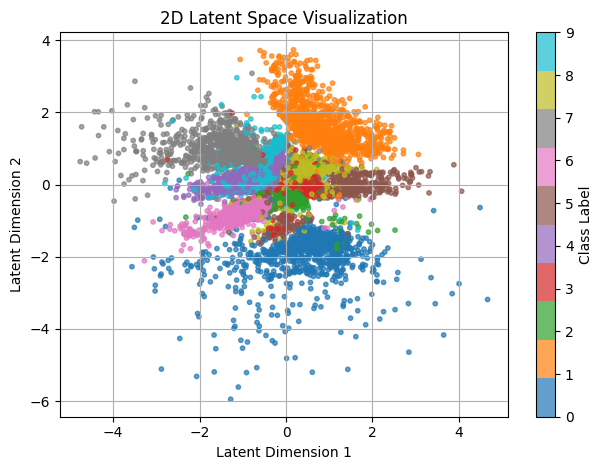

In [35]:
z = samples
labels = classes

scatter = plt.scatter(z[:, 0], z[:, 1], c=labels, cmap=plt.colormaps['tab10'], s=10, alpha=0.7)
cbar = plt.colorbar(scatter, ticks=range(10))
cbar.set_label('Class Label')
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("2D Latent Space Visualization")
plt.grid(True)
plt.tight_layout()
plt.show()

Notice how the means of posterior $p(z|x)$ for same classes gather together. This indicates that there are regions in latent space / prior distribution that correspond to a particular class.

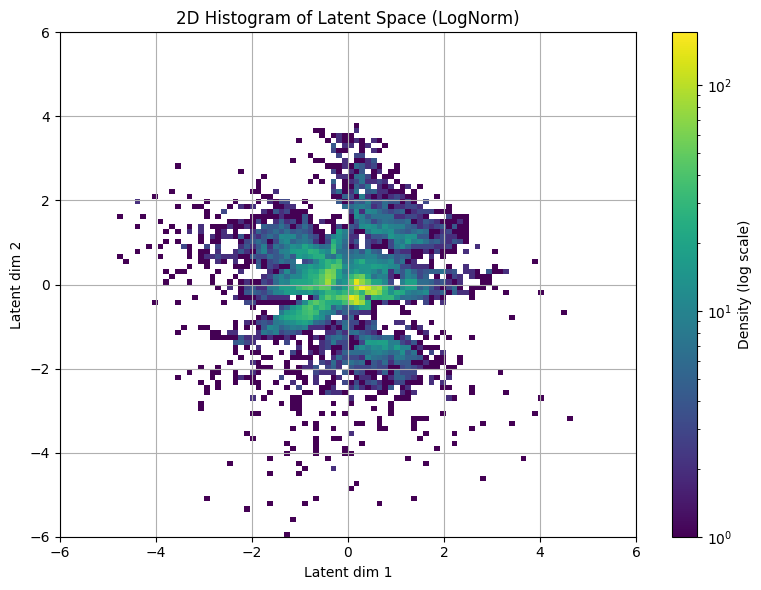

In [37]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(8, 6))
hist = plt.hist2d(
    samples[:, 0], samples[:, 1], 
    bins=100, 
    range=[[-6, 6], [-6, 6]],
    norm=LogNorm(),
    cmap="viridis"
)
plt.colorbar(label='Density (log scale)')
plt.xlabel("Latent dim 1")
plt.ylabel("Latent dim 2")
plt.title("2D Histogram of Latent Space (LogNorm)")
plt.grid(True)
plt.tight_layout()
plt.show()

## Interpolation

Sampling from a straight line parallel to x-axis

In [40]:
n = 16
z1 = torch.linspace(-4, 4, n)
z2 = torch.zeros_like(z1)
z = torch.stack([z1, z2], dim=-1).to(device)

In [41]:
z

tensor([[-4.0000,  0.0000],
        [-3.4667,  0.0000],
        [-2.9333,  0.0000],
        [-2.4000,  0.0000],
        [-1.8667,  0.0000],
        [-1.3333,  0.0000],
        [-0.8000,  0.0000],
        [-0.2667,  0.0000],
        [ 0.2667,  0.0000],
        [ 0.8000,  0.0000],
        [ 1.3333,  0.0000],
        [ 1.8667,  0.0000],
        [ 2.4000,  0.0000],
        [ 2.9333,  0.0000],
        [ 3.4667,  0.0000],
        [ 4.0000,  0.0000]], device='cuda:0')

In [42]:
samples = model.decode(z)
samples = torch.sigmoid(samples)

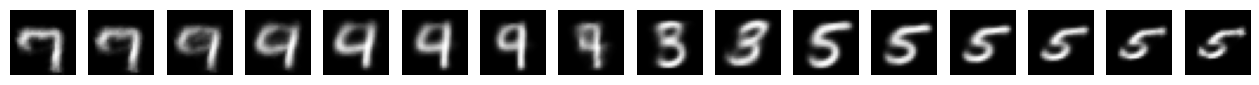

In [43]:
fig, ax = plt.subplots(1, n, figsize=(n, 1))
for i in range(n):
    ax[i].imshow(samples[i].view(28, 28).cpu().detach().numpy(), cmap='gray')
    ax[i].axis('off')

# Conditional VAE

Source: https://ijdykeman.github.io/ml/2016/12/21/cvae.html

In [51]:
input_dim = 784
hidden_dim = 512
latent_dim = 2
n_classes = 10

@dataclass
class VAEOutput:
    x_recon: torch.Tensor
    z_dist: torch.distributions.MultivariateNormal
    z_sample: torch.Tensor
    loss_recon: torch.Tensor
    loss_kl: torch.Tensor
    total_loss: torch.Tensor

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, n_classes):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim + n_classes, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.SiLU(),
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.SiLU(),
            nn.Linear(hidden_dim // 4, hidden_dim // 8),
            nn.SiLU(),
            nn.Linear(hidden_dim // 8, 2 * latent_dim),
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + n_classes, hidden_dim // 8),
            nn.SiLU(),
            nn.Linear(hidden_dim // 8, hidden_dim // 4),
            nn.SiLU(),
            nn.Linear(hidden_dim // 4, hidden_dim // 2),
            nn.SiLU(),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid(),
        )

    
    def encode(self, x, label):
        one_hot = torch.eye(n_classes, dtype=x.dtype, device=x.device)[label]
        x = torch.cat((x, one_hot), dim=-1) # pass label to encoder
        x = self.encoder(x)
        mu, logvar = x.chunk(2, dim=-1)
        std = torch.exp(0.5 * logvar)
        scale_tril = torch.diag_embed(std)

        dist = torch.distributions.MultivariateNormal(
            mu,
            scale_tril=scale_tril
        )
        return dist, mu, logvar

    
    def decode(self, x, label):
        one_hot = torch.eye(n_classes, dtype=x.dtype, device=x.device)[label]
        x = torch.cat((x, one_hot), dim=-1) # pass label to decoder
        return self.decoder(x)

    
    def kl_divergence(self, mu, logvar):
        return torch.mean(-0.5 * torch.sum(1 + logvar - mu.square() - logvar.exp(), dim=-1))

    
    def forward(self, x, label, compute_loss=True):
        dist, mu, logvar = self.encode(x, label)
        z = dist.rsample() # sample using reparameterization
        x_recon = self.decode(z, label)

        if not compute_loss:
            return VAEOutput(
                x_recon = x_recon,
                z_dist = dist,
                z_sample = z,
                loss_recon = None,
                loss_kl = None,
                total_loss = None,
            )

        loss_recon = F.binary_cross_entropy(x_recon, x + 0.5, reduction='none').sum(-1).mean()
        loss_kl = self.kl_divergence(mu, logvar)
        total_loss = loss_recon + loss_kl
        
        return VAEOutput(
            x_recon = x_recon,
            z_dist = dist,
            z_sample = z,
            loss_recon = loss_recon,
            loss_kl = loss_kl,
            total_loss = total_loss,
        )

In [52]:
model = VAE(input_dim, hidden_dim, latent_dim, n_classes).to(device)

In [53]:
x = torch.rand(10, 784) - 0.5
y = torch.randint(0, 10, size=(10,))
x, y

(tensor([[ 0.1989, -0.1419, -0.1468,  ...,  0.3974, -0.1155, -0.4329],
         [-0.1803, -0.0820,  0.0347,  ..., -0.4914, -0.0773,  0.3459],
         [-0.4312,  0.3843,  0.2257,  ...,  0.1145,  0.2876, -0.4668],
         ...,
         [ 0.1578, -0.3755,  0.1215,  ..., -0.1908, -0.1423,  0.2600],
         [ 0.4872, -0.2900,  0.1709,  ...,  0.3590, -0.1596,  0.3665],
         [-0.2738, -0.4407,  0.0418,  ..., -0.0010, -0.3999,  0.2855]]),
 tensor([6, 8, 3, 0, 1, 3, 1, 2, 5, 4]))

In [54]:
model(x.to(device), y.to(device))

VAEOutput(x_recon=tensor([[0.4972, 0.5018, 0.5054,  ..., 0.5097, 0.5081, 0.4882],
        [0.4967, 0.5018, 0.5055,  ..., 0.5103, 0.5082, 0.4887],
        [0.4977, 0.5022, 0.5049,  ..., 0.5096, 0.5087, 0.4888],
        ...,
        [0.4973, 0.5025, 0.5044,  ..., 0.5095, 0.5084, 0.4882],
        [0.4970, 0.5017, 0.5050,  ..., 0.5093, 0.5084, 0.4885],
        [0.4963, 0.5010, 0.5062,  ..., 0.5101, 0.5084, 0.4889]],
       device='cuda:0', grad_fn=<SigmoidBackward0>), z_dist=MultivariateNormal(loc: torch.Size([10, 2]), scale_tril: torch.Size([10, 2, 2])), z_sample=tensor([[ 0.3682,  0.2761],
        [-0.4477, -0.8566],
        [ 0.7497, -0.4305],
        [-0.8197,  1.4819],
        [ 1.2934,  0.9670],
        [-1.9136, -0.4486],
        [ 0.4824, -0.1668],
        [ 1.5759, -0.6957],
        [-0.1933, -0.0340],
        [-1.1852,  0.0614]], device='cuda:0', grad_fn=<AddBackward0>), loss_recon=tensor(543.6165, device='cuda:0', grad_fn=<MeanBackward0>), loss_kl=tensor(0.0089, device='cuda:0',

In [55]:
batch_size = 128
transform = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Lambda(lambda x: x.view(-1) - 0.5),
])

train_dataset = datasets.MNIST(
    'data', 
    download=True, 
    train=True, 
    transform=transform,
)
test_dataset = datasets.MNIST(
    'data', 
    download=True, 
    train=False, 
    transform=transform,
)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True,
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False,
)

In [56]:
def train(dataloader, model, optimizer, epoch):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        output = model(X, y)

        output.total_loss.backward()

        if batch % 100 == 0:
            current = (batch + 1) * len(X)
            loss_recon = output.loss_recon.item()
            loss_kl = output.loss_kl.item()
            total_loss = output.total_loss.item()
            total_norm = torch.nn.utils.get_total_norm(model.parameters())
            print(f"loss_recon: {loss_recon:>7f} loss_kl: {loss_kl:>7f} total_loss: {total_loss:>7f}  [{current:>5d}/{size:>5d}]")

            
            step = epoch * len(dataloader) + batch
            writer.add_scalar('Loss/Train', total_loss, step)
            writer.add_scalar('Loss/Train/BCE', loss_recon, step)
            writer.add_scalar('Loss/Train/KLD', loss_kl, step)
            writer.add_scalar('GradNorm/Train', total_norm, step)

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        optimizer.zero_grad()


def test(dataloader, model, loss_fn, epoch):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    loss_recon, loss_kl, total_loss = 0.0, 0.0, 0.0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            output = model(X, y)
            loss_recon += output.loss_recon.item()
            loss_kl += output.loss_kl.item()
            total_loss += output.total_loss.item()
    loss_recon /= len(dataloader)
    loss_kl /= len(dataloader)
    total_loss /= len(dataloader)
    print(f"Test Error: \n Avg loss_recon: {loss_recon:>7f} Avg loss_kl: {loss_kl:>7f} Avg total_loss: {total_loss:>7f} \n")

    writer.add_scalar('Loss/Test', total_loss, epoch)
    writer.add_scalar('Loss/Test/BCE', loss_recon, epoch)
    writer.add_scalar('Loss/Test/KLD', loss_kl, epoch)

    writer.add_images('Test/Reconstructions', output.x_recon.view(-1, 1, 28, 28), epoch)
    writer.add_images('Test/Originals', X.view(-1, 1, 28, 28), epoch)

    z = torch.randn(1, latent_dim).expand(16, -1).to(device)
    label = torch.randint(0, 10, size=(16,)).to(device)
    samples = model.decode(z, label)
    writer.add_images('Test/Samples', samples.view(-1, 1, 28, 28), epoch)

In [57]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## Load

In [58]:
model.load_state_dict(torch.load('cvae.pt'))

<All keys matched successfully>

## Train

In [582]:
epochs = 50
writer = SummaryWriter(f'runs/mnist/cvae_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, optimizer, t)
    test(test_dataloader, model, loss_fn, t)
print("Done!")

Epoch 1
-------------------------------
loss_recon: 544.024292 loss_kl: 0.018978 total_loss: 544.043274  [  128/60000]
loss_recon: 198.027374 loss_kl: 1.499648 total_loss: 199.527023  [12928/60000]
loss_recon: 183.427399 loss_kl: 1.872149 total_loss: 185.299545  [25728/60000]
loss_recon: 173.603668 loss_kl: 2.033659 total_loss: 175.637329  [38528/60000]
loss_recon: 163.928802 loss_kl: 2.029570 total_loss: 165.958374  [51328/60000]
Test Error: 
 Avg loss_recon: 161.589768 Avg loss_kl: 2.047274 Avg total_loss: 163.637041 

Epoch 2
-------------------------------
loss_recon: 162.880722 loss_kl: 2.090696 total_loss: 164.971420  [  128/60000]
loss_recon: 158.092270 loss_kl: 3.027404 total_loss: 161.119675  [12928/60000]
loss_recon: 141.545547 loss_kl: 3.961622 total_loss: 145.507172  [25728/60000]
loss_recon: 142.630768 loss_kl: 4.016894 total_loss: 146.647659  [38528/60000]
loss_recon: 140.209473 loss_kl: 4.224292 total_loss: 144.433762  [51328/60000]
Test Error: 
 Avg loss_recon: 136.9875

In [616]:
torch.save(model.state_dict(), 'cvae.pt')

## Experiment

In [59]:
samples, classes = [], []
for X, y in test_dataloader:
    _, mu, _ = model.encode(X.to(device), y)
    samples.append(mu.detach().cpu().numpy())
    classes.append(y)

In [60]:
samples = np.concatenate(samples, axis=0)
classes = np.concatenate(classes)

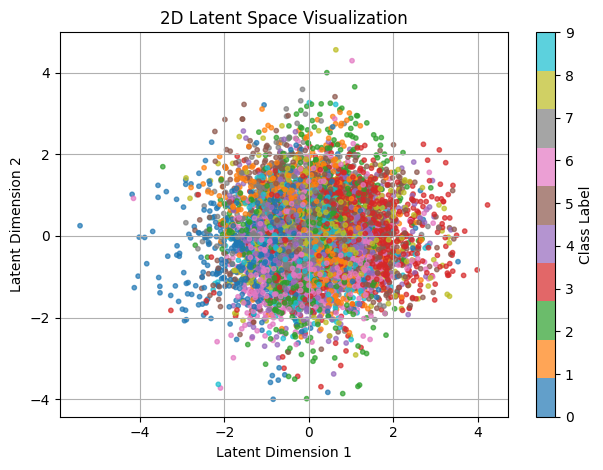

In [61]:
z = samples
labels = classes

scatter = plt.scatter(z[:, 0], z[:, 1], c=labels, cmap=plt.colormaps['tab10'], s=10, alpha=0.7)
cbar = plt.colorbar(scatter, ticks=range(10))
cbar.set_label('Class Label')
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("2D Latent Space Visualization")
plt.grid(True)
plt.tight_layout()
plt.show()

What???

The posterior distributions $p(z|x,y)$ for same the class unlike unconditional VAE do not gather together and are evenly spread across the latent space / prior distribution. This is because now the latent space only stores the information of the stokes like width and angle of the handwritten images and the class information is provided by the label to the decoder.

## Let's try sampling

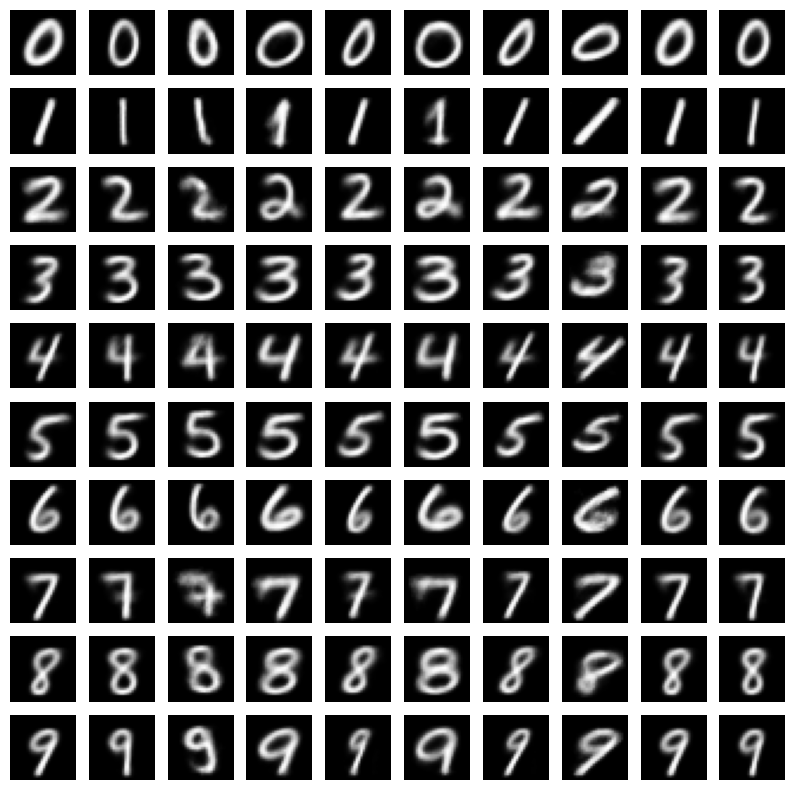

In [611]:
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
z = torch.randn(10, latent_dim).repeat(10, 1).to(device)
label = torch.arange(10).repeat_interleave(10, dim=0).to(device)
img = model.decode(z, label).detach().cpu().numpy().reshape(10, 10, 28, 28)
for i in range(10):
    for j in range(10):
        axes[i][j].imshow(img[i][j], cmap='gray')
        axes[i][j].axis('off')

A row has same class label but different prior samples and a column has same prior sample but different class label